# Image Caption Generator

This project is an analysis of some images where the deep learning models recognize the context of the images and describe them in natural language - English here.

All the libraries needed are imported

In [91]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add, Concatenate, Reshape

## Data Collection

The data used in this analysis consists of two datasets -
1. Flickr8k dataset 
2. IAPRTC12 dataset

## Data Preprocessing

The captions of these two datasets are stored in two separate files. The captions are loaded and these are stored in a dictionary with image name as key and captions as value in the form of any array. These are later cleaned to remove noise in the captions.

### Load captions data

In [2]:
# Reading the captions file
with open('Data/captions_dataset1.txt', 'r') as file:
    captions_dataset1 = file.readlines()
    
with open('Data/captions_dataset2.txt', 'r') as file:
    captions_dataset2 = file.readlines()

In [3]:
# Mapping the image and captions into a dictionary
mapping = {}

# Dataset1
for line in captions_dataset1[1:]:
    tokens = line.split(',')
    key = tokens[0]
    caption = tokens[1]
    if key not in mapping:
        mapping[key] = []
    mapping[key].append(caption)

# Dataset2
for line in captions_dataset2[1:]:
    tokens = line.split(';')
    key = tokens[0]
    caption = tokens[1]
    if key not in mapping:
        mapping[key] = []
    mapping[key].append(caption)

print("Total number of images: " + str(len(mapping)))

Total number of images: 12800


### Cleaning the captions

The captions are cleaned such that irrelevant characters such as digits, special characters are removed. Also, extra spaces are trimmed. The case of all captions are made lower.

In [4]:
# Converting the case and replacing irrelevant characters 
for image, captions in mapping.items():
    for i in range(len(captions)):
        cleaned_caption = captions[i].lower().replace('[^A-Za-z]', '').replace('\s+', ' ')
        processed_caption = 'startseq ' + " ".join([word for word in cleaned_caption.split() if len(word)>1]) + ' endseq'
        captions[i] = processed_caption

In [5]:
# Storing all the possible captions into a list for tokenization
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
print("Total number of possible captions: " + str(len(all_captions)))

Total number of possible captions: 48899


In [6]:
# Processed captions after cleaning
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Tokenize the captions

The captions are tokenized such that the captions are broken down into smaller units for analysis. Further, the maximum caption length is identified which will be used as reference of padding sequence.

In [7]:
# Tokenizing all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

print("Total number of words in the vocabulary: " + str(vocab_size))

Total number of words in the vocabulary: 8832


In [8]:
# Getting the maximum length of the longest caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

48

### Extraction of Image features

The features of the images are extracted using pre-trained model. The features extracted are used for training.

In [22]:
# Loading the pre-trained VGG16 model to extract features from images
saved_model_path = r'D:\Gundu\Masters\Courses\Spring-2024\DataMining\Assignments\Project\ImageCaptionGenerator\PipCache\vgg16_weights_tf_dim_ordering_tf_kernels.h5'
model = VGG16(weights=saved_model_path)
print(model.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
# Extracting features from two datasets
features = {}
dataset1_path = 'Data/Images_Dataset1'
dataset2_path = 'Data/Images_Dataset2'

# Dataset 1
for img_name in os.listdir(dataset1_path):
    # Loading the images with size 224 * 224
    img_path = dataset1_path + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Converting the image to numpy array
    image = img_to_array(image)
    # The data is reshaped for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # The image loaded is processed so that it is suitable for VGG16 prediction
    image = preprocess_input(image)
    # Extracting the features from the model
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    # Storing the feature such that value is the feature predicted and the image name is the key
    features[image_id] = feature

# Dataset 2
for img_name in os.listdir(dataset2_path):
    # Loading the images with size 224 * 224
    img_path = dataset2_path + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Converting the image to numpy array
    image = img_to_array(image)
    # The data is reshaped for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # The image loaded is processed so that it is suitable for VGG16 prediction
    image = preprocess_input(image)
    # Extracting the features from the model
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    # Storing the feature such that value is the feature predicted and the image name is the key
    features[image_id] = feature

print("Total length of the features dictionary after extraction: " + str(len(features)))

Total length of the features dictionary after extraction: 12800


In [29]:
# Storing extracted features in pickle file
with open('features.pkl', 'wb') as file:
    pickle.dump(features, file)

The features are stored in a pickle file as above so that it can be re-used without re-running extraction of features again and again.

In [9]:
# Loading the extracted features from pickle file
with open('features.pkl', 'rb') as file:
    extracted_features = pickle.load(file)

In [10]:
len(extracted_features)

12800

### Creation of train and test data

The dataset is divided into training and test data with 90% of the total dataset as training data and remaining 10% is used as test data. The data is sampled, so that the two datasets are shuffled and training and test sets have data from both the datasets.

In [79]:
import random 

# Sampling the image ids from the dictionary
mapping_ids = [id.split('.')[0] for id in mapping.keys()]
image_ids = random.sample(mapping_ids, len(mapping_ids))
# Split value such that 90% is used for training 
split = int(len(image_ids) * 0.9)
train_ids = image_ids[:split]
test_ids = image_ids[split:]

print("Number of training images: " + str(len(train_ids)))
print("Number of test images: " + str(len(test_ids)))

Number of training images: 11520
Number of test images: 1280


A batch is created and padding sequence is included. This will be helpful to normalize the size of captions to the maximum length by filling them with zeros.

In [88]:
# Data generator is created to get the data in a batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key+".jpg"]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

### CNN and LSTM 

#### Model Creation

The model consists of encoder-decoder architecture for sequence-to-sequence tasks. 

The encoder processes images and captions separately, and the decoder combines the encoded representations obtained from encoder and tries to predict the next word in the sequence.

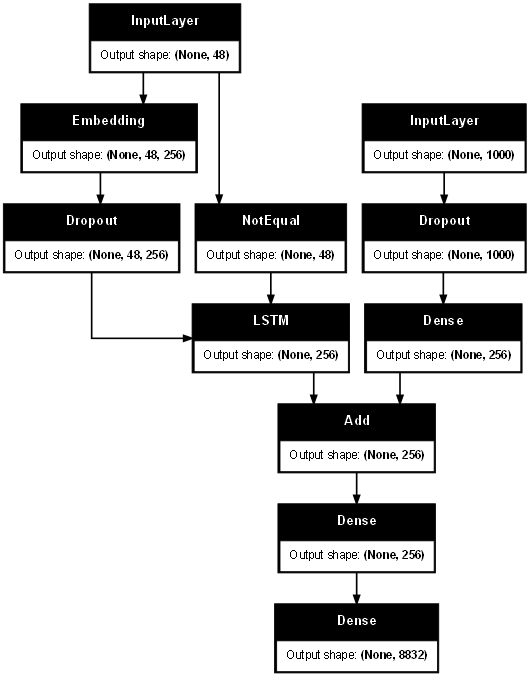

In [94]:
# Encoder model
# Input layer 1 for images

inputs1 = Input(shape=(1000,))
# Dropout layer 
fe1 = Dropout(0.4)(inputs1)
# Dense layer to transform image features to lower dimension
fe2 = Dense(256, activation='relu')(fe1)

# Input layer 2 for captions
inputs2 = Input(shape=(max_length,))
# Embedding layer to map each integer representing a word in the vocabulary
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# Dropout layer
se2 = Dropout(0.4)(se1)
# LSTM layer 
se3 = LSTM(256)(se2)

# Decoder model
# Combination of both input layers from images and captions
decoder1 = add([fe2, se3])
# Dense layer to add activation unit for concatenated features
decoder2 = Dense(256, activation='relu')(decoder1)
# Output layer
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Defining the model with two input layers and one output layer
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plotting the model
plot_model(model, show_shapes=True, dpi=60)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train_ids) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_ids, mapping, extracted_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

360/360 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - loss: 4.2220
340/360 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - loss: 3.8042

In [ ]:
model.save('model.h5')